## The Battle of Neighborhoods (Week 1)

### Introduction/Business Problem

Toronto is one of the most densely populated areas in Canada. Being the land of opportunity, it brings in a variety of people from different ethnic backgrounds to the core city of Canada, Toronto. Being the largest city in Canada with an estimated population of over 6 million, there is no doubt about the diversity of the population. Multiculturalism is seen through the various neighbourhoods including; Chinatown, Corso Italia, Little India, Kensington Market, Little Italy, Koreatown and many more. Downtown Toronto being the hub of interactions between ethnicities brings many opportunities for entrepreneurs to start or grow their business. It is a place where people can try the best of each culture, either while they work or just passing through. Toronto is well known for its great food.

The objective of this project is to use Foursquare location data and regional clustering of venue information to determine what might be the ‘best’ neighbourhood in Toronto to open a restaurant. There are 631,050 Chinese in the Greater Toronto Area as of the 2016 census, second only to New York City for largest Chinese community in North America. So there are numerous opportunities to open a new Chinese restaurant. Through this project, we will find the most suitable location for an entrepreneur to open a new Chinese restaurant in Toronto, Canada.

### Target Audience

Entrepreneur or business owner who wants to open Chinese restaurant in Toronto but is uncertain about which neighborhood.

### Data Section

The data will be a combination of CSV files that have been prepared for the purposes of the analysis from multiple sources which will provide the list of neighbourhoods in Toronto (via Wikipedia), the Geographical location of the neighbourhoods (via Geocoder package) and Venue data pertaining to Italian restaurants (via Foursquare). The Venue data will help find which neighbourhood is best suitable to open an Italian restaurant.

**Source 1: Toronto Neighborhoods via Wikipedia**

https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
        
The Wikipedia site shown above provided almost all the information about the neighbourhoods. It included the postal code, borough and the name of the neighbourhoods present in Toronto. Since the data is not in a format that is suitable for analysis, scraping of the data was done from this site

**Source 2: Geographical Location data using Geocoder Package**

http://cocl.us/Geospatial_data
    
The second source of data provided us with the Geographical coordinates of the neighbourhoods with the respective Postal Codes. The file was in CSV format, so we had to attach it to a Pandas data frame

**Source 3: Venue Data using Foursquare API**

By using this API we will get all the venues in each neighbourhood. We can filter these venues to get only Indian restaurants.

In [1]:
!pip install folium

In [2]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [4]:
# Now we will read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [5]:
df = pd.read_html(table_str)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Remove Not assigned Boroughs

In [6]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

Rename Postal Code to PostalCode

In [7]:
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

In [8]:
df = df_dropna
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Group the data based on Borough

In [9]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

,Borough,PostalCode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [10]:
# Check if we still have any Neighborhoods that are Not Assigned
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

,Borough,PostalCode,Neighbourhood


Add the Latitude and Longitudes of each location

In [11]:
df = df_grouped
df.shape

(103, 3)

In [12]:
# Rearrange columns for easier readibility
df = df[['PostalCode', 'Borough', 'Neighbourhood']]
df.head()

,PostalCode,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


Create a new table with the Latitudes and Longitudes corresponding to the different PostalCodes

In [13]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the data, based on the postal code.

In [14]:
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [15]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

Find all neighborhoods that have the Toronto in it

In [16]:
df_toronto = df
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [17]:
#Create list with the Boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [18]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.3971529116505


In [19]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [20]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

Define foursquare Credentials

In [21]:
CLIENT_ID = '0GY4VKXPUIOTESPWNPMGREYHRJOND41JCA1MMZURLOTSXHFG' # your Foursquare ID
CLIENT_SECRET = 'MOQ0NKWQL1F1LRFPHEQWWESYYP3L5PJKVQC0KEJU0AABGH4Q' # your Foursquare Secret
VERSION = '20201129' # Foursquare API version

print('Credentials Stored')

Credentials Stored


Obtain the venues from all neighbourhoods in Toronto

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

Check how many venues were returned for each neighbourhood

In [24]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,9,9,9,9,9,9


how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 277 uniques categories.


In [26]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Swim School' 'Bus Line' 'Breakfast Spot' 'Food & Drink Shop'
 'Department Store' 'Hotel' 'Sandwich Place' 'Gym / Fitness Center'
 'Dog Run' 'Dance Studio' 'Yoga Studio' 'Spa' 'Salon / Barbershop' 'Diner'
 'Clothing Store' 'Restaurant' 'Mexican Restaurant' 'Coffee Shop'
 'Chinese Restaurant' 'Sporting Goods Shop' 'Fast Food Restaurant' 'Café'
 'Ice Cream Shop' 'Furniture / Home Store' 'Bagel Shop' 'Dessert Shop'
 'Indian Restaurant' 'Pizza Place' 'Seafood Restaurant' 'Sushi Restaurant'
 'Italian Restaurant' 'Thai Restaurant' 'Brewery' 'Gym' 'Toy / Game Store'
 'Greek Restaurant' 'Gas Station' 'Farmers Market' 'Gourmet Shop'
 'Candy Store' 'Pharmacy' 'Indoor Play Area' 'Trail' 'Playground'
 'Liquor Store' 'Supermarket' 'American Restaurant' 'Pub'
 'Vietnamese Restaurant' 'Fried Chicken Joint' 'Bank' 'Light Rail Station'
 'Garden' 'Music Venue' 'Dive Bar' 'Jewelry Store'
 'Middle Eastern Restaurant' 'BBQ Joint' 'Burger Joint' 'Donut Shop'
 'History Museum

### Are there any Chinese Restaurants in the venues?

In [27]:
"Chinese Restaurant" in toronto_venues['Venue Category'].unique()

True

**Analyze each neighborhood**

In [28]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2167, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(96, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
chn = to_grouped[["Neighborhoods","Chinese Restaurant"]]
chn.head() #.head() shows the first five rows only

,Neighborhoods,Chinese Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619
3,Bayview Village,0.250000
4,"Bedford Park, Lawrence Manor East",0.000000


In [31]:
chn = chn.rename(columns={'Neighborhoods':'Neighborhood'})

### Cluster the neighborhoods

We will use k-means clustering. But first we will find the best K using the Elbow Point method.

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = chn.drop(['Neighborhood'], axis=1)

In [33]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 2, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [34]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [35]:
scores = [get_inertia(x) for x in range(2, 21)]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/

Text(0, 0.5, 'Error')

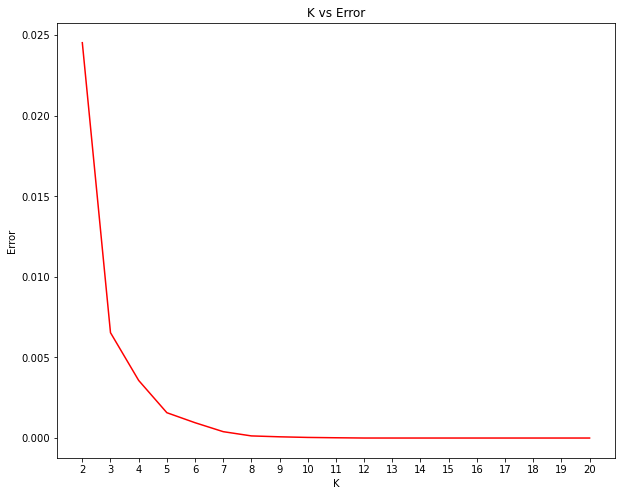

In [36]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

We see that the optimum K value is 4 so we will have a resulting of 4 clusters

In [37]:
kclusters = 4

toronto_grouped_clustering = chn.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [38]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = chn.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [39]:
to_merged.head()

,Neighborhood,Chinese Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,2
3,Bayview Village,0.250000,1
4,"Bedford Park, Lawrence Manor East",0.000000,0


In [40]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2167, 9)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


In [41]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2167, 9)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.000000,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,JaBistro,43.649687,-79.388090,Sushi Restaurant
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Friendly Stranger - Cannabis Culture Shop,43.650387,-79.388523,Smoke Shop
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Cactus Club Cafe,43.649552,-79.381671,American Restaurant
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Adelaide Club Toronto,43.649279,-79.381921,Gym / Fitness Center
...,...,...,...,...,...,...,...,...,...
23,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Pho Vietnam,43.757770,-79.278572,Vietnamese Restaurant
23,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
23,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant
87,Westmount,0.166667,3,43.696319,-79.532242,Subway,43.692927,-79.531471,Sandwich Place


Check how many Chinese Restaurant are there

In [42]:
to_merged['Venue Category'].value_counts()['Chinese Restaurant']

16

We see that there are a total of 16 locations with Chinese Restaurants in Toronto
We will create a new dataframe with the Neighborhood and Chinese Restaurants

In [43]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

**How many Neighborhoods per Cluster?**

In [44]:
chn["Cluster Labels"] = kmeans.labels_
chn.head()

,Neighborhood,Chinese Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,2
3,Bayview Village,0.250000,1
4,"Bedford Park, Lawrence Manor East",0.000000,0


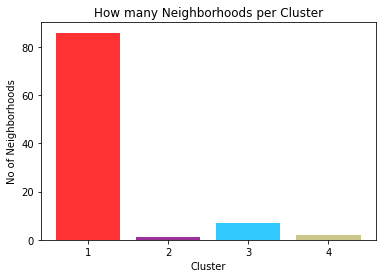

In [45]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = chn['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','deepskyblue', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [46]:
# How many neighborhoods in each cluster
chn['Cluster Labels'].value_counts()

0    86
2     7
3     2
1     1
Name: Cluster Labels, dtype: int64

## Analysis of each Cluster

**Cluster 1**

In [47]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighbourhood']]
df_new.head()

,Borough,Neighbourhood
0,Central Toronto,Lawrence Park
1,Central Toronto,Davisville North
2,Central Toronto,"North Toronto West, Lawrence Park"
3,Central Toronto,Davisville
4,Central Toronto,"Moore Park, Summerhill East"


In [48]:
df_new.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True) 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
df_new.head()

,Borough,Neighborhood
0,Central Toronto,Lawrence Park
1,Central Toronto,Davisville North
2,Central Toronto,"North Toronto West, Lawrence Park"
3,Central Toronto,Davisville
4,Central Toronto,"Moore Park, Summerhill East"


In [50]:
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1

,Borough,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
1,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
3,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Love To Dance,43.708387,-79.390558,Dance Studio
...,...,...,...,...,...,...,...,...,...,...
2026,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,195 Jane Rocket,43.672335,-79.492634,Bus Line
2027,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,Starving Artist,43.669860,-79.483110,Breakfast Spot
2028,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,High Park Brewery,43.669903,-79.483430,Brewery
2029,York,Weston,0.0,0,43.706876,-79.518188,Wallace C. Swanek Park,43.708896,-79.522648,Park


**Cluster 2**

In [51]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2

,Borough,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Bayview Village,0.25,1,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant
1,North York,Bayview Village,0.25,1,43.786947,-79.385975,TD Canada Trust,43.788074,-79.380367,Bank
2,North York,Bayview Village,0.25,1,43.786947,-79.385975,Maxim's Cafe and Patisserie,43.787863,-79.380751,Café
3,North York,Bayview Village,0.25,1,43.786947,-79.385975,Kaga Sushi,43.787758,-79.381090,Japanese Restaurant


**Cluster 3**

In [52]:
# Deep sky blue
cluster3=to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

,Borough,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,The Bagel House,43.714004,-79.399953,Bagel Shop
1,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,Degrees Kitchen Store,43.714307,-79.399882,Furniture / Home Store
2,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,Milkcow,43.715907,-79.400125,Ice Cream Shop
3,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,St. Clements - Yonge Parkette,43.712062,-79.404255,Park
4,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,Second Cup,43.714583,-79.400120,Café
...,...,...,...,...,...,...,...,...,...,...
192,Scarborough,"Steeles West, L'Amoreaux West",0.076923,2,43.799525,-79.318389,KFC,43.798938,-79.318854,Fast Food Restaurant
193,Scarborough,"Steeles West, L'Amoreaux West",0.076923,2,43.799525,-79.318389,Price Chopper,43.799445,-79.318563,Grocery Store
194,Scarborough,"Steeles West, L'Amoreaux West",0.076923,2,43.799525,-79.318389,Subway,43.798671,-79.318475,Sandwich Place
195,Scarborough,"Steeles West, L'Amoreaux West",0.076923,2,43.799525,-79.318389,RBC Royal Bank,43.798236,-79.317952,Bank


**Cluster 4**

In [53]:
# Dark khaki
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

,Borough,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Starbucks,43.696338,-79.533398,Coffee Shop
1,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Pizza Hut,43.696431,-79.533233,Pizza Place
2,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Dollarama,43.691945,-79.531593,Discount Store
3,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Dixon & Royal York,43.700013,-79.534408,Intersection
4,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Subway,43.692927,-79.531471,Sandwich Place
5,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Mayflower Chinese Food,43.692753,-79.531566,Chinese Restaurant
6,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Big Al's Pet Supercentre,43.759279,-79.278325,Pet Store
7,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
8,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Pho Vietnam,43.757770,-79.278572,Vietnamese Restaurant
9,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant


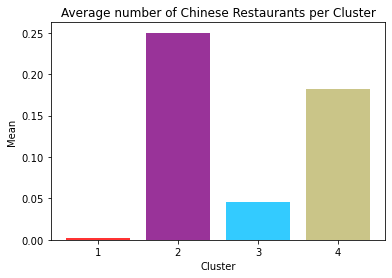

In [54]:
clusters_mean = [df_cluster1['Chinese Restaurant'].mean(),df_cluster2['Chinese Restaurant'].mean(),df_cluster3['Chinese Restaurant'].mean(),
                 df_cluster4['Chinese Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','deepskyblue', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Chinese Restaurants per Cluster')

plt.show()